# Description

In this notebook I'm trying create a simple mode for stock selection based on Joel Greenblat's
Magic Formula. It's been a while since I read his book but I believe he ranked stocks by EV/EVIT and
ROIC and selected the top 30 that had a combined best score and held the stocks for a year. I'm using
ROA instead of ROIC and hope that does well enough.

I got the data from the SimFin free tier. I believe they give about 5 years of historical data for US
stocks and it is not quite recent

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import seaborn as sns

# Import the main functionality from the SimFin Python API.
import simfin as sf
# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [2]:
# SimFin data-directory.
sf.set_data_dir('~/.simfin/data/')
# SimFin load API key or use free data.
sf.load_api_key(path='~/.simfin/api-key.txt', default_key='free')

In [3]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

In [4]:
# We are interested in the US stock-market.
market = 'us'
# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

In [5]:
# %%time
# hub = sf.StockHub(market=market, offset=offset,
#                   refresh_days=refresh_days,
#                   refresh_days_shareprices=refresh_days_shareprices)

CPU times: total: 0 ns
Wall time: 0 ns


## Load Data

In [ ]:
%%time
# Data for USA.
market = 'us'
# TTM Income Statements.
df_income_ttm = sf.load_income(variant='ttm', market=market)
# Quarterly Income Statements.
df_income_qrt = sf.load_income(variant='quarterly', market=market)
# TTM Balance Sheets.
df_balance_ttm = sf.load_balance(variant='ttm', market=market)
# Quarterly Balance Sheets.
df_balance_qrt = sf.load_balance(variant='quarterly', market=market)
# TTM Cash-Flow Statements.
df_cashflow_ttm = sf.load_cashflow(variant='ttm', market=market)
# Quarterly Cash-Flow Statements.
df_cashflow_qrt = sf.load_cashflow(variant='quarterly', market=market)
# Daily Share-Prices.
df_prices = sf.load_shareprices(variant='daily', market=market)

In [64]:
len(set(df_prices.index.get_level_values(0)))

5195

In [9]:
p_ticks = set(df_prices.index.get_level_values(0))
i_ticks = set(df_income_ttm.index.get_level_values(0))
b_ticks = set(df_balance_ttm.index.get_level_values(0))
c_ticks = set(df_cashflow_ttm.index.get_level_values(0))

all_ticks = p_ticks.intersection(i_ticks, b_ticks, c_ticks)

In [11]:
tickers = list(all_ticks)
len(tickers)

3922

In [13]:
#tickers = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'META', 'GOOG', 'LLY', 'AVGO', 'TSLA', 'UNH']

df_income_ttm = df_income_ttm.loc[tickers].copy()
df_balance_ttm = df_balance_ttm.loc[tickers].copy()
df_cashflow_ttm = df_cashflow_ttm.loc[tickers].copy()
df_prices = df_prices.loc[tickers].copy()

In [10]:
df_income_ttm.tail()

SimFinId Currency  Fiscal Year Fiscal Period Publish Date  \
Ticker Report Date                                                              
AMP    2022-06-30      67872      USD         2022            Q2   2022-08-01   
       2022-09-30      67872      USD         2022            Q3   2022-11-02   
       2022-12-31      67872      USD         2022            Q4   2023-02-23   
       2023-03-31      67872      USD         2023            Q1   2023-05-02   
       2023-06-30      67872      USD         2023            Q2   2023-08-08   

                   Restated Date  Shares (Basic)  Shares (Diluted)  \
Ticker Report Date                                                   
AMP    2022-06-30     2023-08-08     113800000.0       116450000.0   
       2022-09-30     2023-11-02     113225000.0       115650000.0   
       2022-12-31     2023-11-02     111800000.0       114100000.0   
       2023-03-31     2024-05-06     110350000.0       112550000.0   
       2023-06-30     2023-08-08     108875000.0       111050000.0   

                         Revenue  Cost of Revenue  ...  \
Ticker Report Date                                 ...   
AMP    2022-06-30   1.373400e+10              NaN  ...   
       2022-09-30   1.433000e+10              NaN  ...   
       2022-12-31   1.433100e+10    -6.060000e+09  ...   
       2023-03-31   1.444600e+10    -7.448000e+09  ...   
       2023-06-30   1.483600e+10    -7.464000e+09  ...   

                    Non-Operating Income (Loss)  Interest Expense, Net  \
Ticker Report Date                                                       
AMP    2022-06-30                   -48000000.0           -190255303.0   
       2022-09-30                   136000000.0           -178195597.0   
       2022-12-31                  -339000000.0           -198040912.0   
       2023-03-31                  -230000000.0           -230000000.0   
       2023-06-30                  -270000000.0           -270000000.0   

                    Pretax Income (Loss), Adj.  Abnormal Gains (Losses)  \
Ticker Report Date                                                        
AMP    2022-06-30                   4014893196             -449000000.0   
       2022-09-30                   3424826115             -127000000.0   
       2022-12-31                   3181762335             -312000000.0   
       2023-03-31                   2677248242             -702000000.0   
       2023-06-30                   3019121895              -83000000.0   

                    Pretax Income (Loss)  Income Tax (Expense) Benefit, Net  \
Ticker Report Date                                                            
AMP    2022-06-30             4750000000                       -764368037.0   
       2022-09-30             4815000000                       -662225894.0   
       2022-12-31             3931000000                       -622183681.0   
       2023-03-31             3421000000                       -520956186.0   
       2023-06-30             3775000000                       -598883163.0   

                    Income (Loss) from Continuing Operations  \
Ticker Report Date                                             
AMP    2022-06-30                                 3245877417   
       2022-09-30                                 2761443092   
       2022-12-31                                 2557506138   
       2023-03-31                                 2156260345   
       2023-06-30                                 2430685925   

                    Net Extraordinary Gains (Losses)  Net Income  \
Ticker Report Date                                                 
AMP    2022-06-30                                NaN  3246113644   
       2022-09-30                                NaN  2767903519   
       2022-12-31                                NaN  2558435888   
       2023-03-31                                NaN  2154183758   
       2023-06-30                                NaN  2425600540   

                    Net Incom

<Axes: xlabel='Date'>

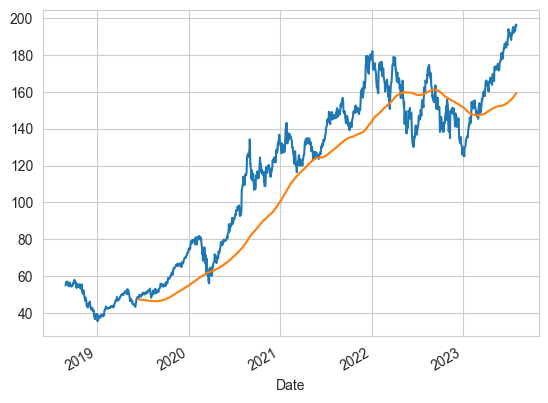

In [14]:
# Plot the raw share-prices.
df_prices.loc['AAPL', CLOSE].plot()

# Overlay plot of 200-day moving average.
df_prices.loc['AAPL', CLOSE].rolling(window=200).mean().plot()

## FIN Singals from ST

In [15]:
df_income_ttm.shape, df_balance_ttm.shape, df_cashflow_ttm.shape, df_prices.shape

((59292, 26), (59289, 28), (59289, 26), (4051164, 9))

In [ ]:
df_fin_signals = sf.fin_signals(df_prices=df_prices,
                                df_income_ttm=df_income_ttm,
                                df_balance_ttm=df_balance_ttm,
                                df_cashflow_ttm=df_cashflow_ttm,
                                fill_method='ffill')

df_fin_signals.dropna().head()

## VAL Signals

In [33]:
df_val_signals = sf.val_signals(df_prices=df_prices,
                                df_income_ttm=df_income_ttm,
                                df_balance_ttm=df_balance_ttm,
                                df_cashflow_ttm=df_cashflow_ttm)
df_val_signals.dropna().head()

Dividend Yield  Earnings Yield  FCF Yield    Market-Cap  \
Ticker Date                                                                  
ACN    2018-08-31        0.015423        0.036645   0.048808  1.107909e+11   
       2018-09-04        0.015384        0.036552   0.048684  1.110727e+11   
       2018-09-05        0.015462        0.036738   0.048933  1.105091e+11   
       2018-09-06        0.015397        0.036582   0.048725  1.109810e+11   
       2018-09-07        0.015423        0.036645   0.048808  1.107909e+11   

                      P/Cash        P/E      P/FCF      P/NCAV   P/NetNet  \
Ticker Date                                                                 
ACN    2018-08-31  21.875759  27.289029  20.488366 -797.424138 -36.385524   
       2018-09-04  21.931396  27.358434  20.540474 -799.452247 -36.478064   
       2018-09-05  21.820122  27.219624  20.436257 -795.396029 -36.292984   
       2018-09-06  21.913282  27.335837  20.523509 -798.791933 -36.447935   
       2018-09-07  21.875759  27.289029  20.488366 -797.424138 -36.385524   

                    P/Sales  Price to Book Value  
Ticker Date                                       
ACN    2018-08-31  2.713977            10.330553  
       2018-09-04  2.720879            10.356827  
       2018-09-05  2.707074            10.304279  
       2018-09-06  2.718632            10.348272  
       2018-09-07  2.713977            10.330553

## Enterprise Value

In [17]:
def ev_to_ebit(df_income_ttm, df_balance_ttm, df_prices):
    short_cash = 'Cash, Cash Equivalents & Short Term Investments'
    df_balance_daily = sf.signals.reindex(df_balance_ttm, df_prices, method='ffill', group_index=TICKER)
    df_income_daily = sf.signals.reindex(df_income_ttm, df_prices, method='ffill', group_index=TICKER)
    df_signals = pd.DataFrame(index=df_prices.index)
    df_signals[MARKET_CAP] = df_balance_daily['Shares (Diluted)'] * df_prices[CLOSE]
    df_signals['EV'] = df_signals[MARKET_CAP] + df_balance_daily[ST_DEBT] + df_balance_daily[LT_DEBT] - df_balance_daily[short_cash]
    df_signals['EBIT'] = df_income_daily[NET_INCOME].fillna(0) \
              - df_income_daily[INTEREST_EXP_NET].fillna(0) \
              - df_income_daily[INCOME_TAX].fillna(0) 
    df_signals['EV/EBIT'] = df_signals['EV'] / df_signals['EBIT']
    return df_signals.dropna()
    

In [18]:
factors_df = ev_to_ebit(df_income_ttm, df_balance_ttm, df_prices)
factors_df

Market-Cap            EV         EBIT   EV/EBIT
Ticker Date                                                        
PKE    2019-05-31  305635050.0  1.550403e+08  112611366.0  1.376773
       2019-06-03  312181450.0  1.615867e+08  112611366.0  1.434906
       2019-06-04  314840925.0  1.642462e+08  112611366.0  1.458522
       2019-06-05  315659225.0  1.650645e+08  112611366.0  1.465789
       2019-06-06  312386025.0  1.617913e+08  112611366.0  1.436722
...                        ...           ...          ...       ...
REPX   2023-07-26  716560900.0  1.110727e+09  205598000.0  5.402422
       2023-07-27  714370800.0  1.108537e+09  205598000.0  5.391770
       2023-07-28  730099700.0  1.124266e+09  205598000.0  5.468273
       2023-07-31  745629500.0  1.139796e+09  205598000.0  5.543808
       2023-08-01  734479900.0  1.128646e+09  205598000.0  5.489578

[3047461 rows x 4 columns]

## Add Return on Assets

In [19]:
factors_df["ROA"] = df_fin_signals["Return on Assets"]
factors_df

Market-Cap            EV         EBIT   EV/EBIT       ROA
Ticker Date                                                                  
PKE    2019-05-31  305635050.0  1.550403e+08  112611366.0  1.376773  0.595566
       2019-06-03  312181450.0  1.615867e+08  112611366.0  1.434906  0.595566
       2019-06-04  314840925.0  1.642462e+08  112611366.0  1.458522  0.595566
       2019-06-05  315659225.0  1.650645e+08  112611366.0  1.465789  0.595566
       2019-06-06  312386025.0  1.617913e+08  112611366.0  1.436722  0.595566
...                        ...           ...          ...       ...       ...
REPX   2023-07-26  716560900.0  1.110727e+09  205598000.0  5.402422  0.162613
       2023-07-27  714370800.0  1.108537e+09  205598000.0  5.391770  0.162613
       2023-07-28  730099700.0  1.124266e+09  205598000.0  5.468273  0.162613
       2023-07-31  745629500.0  1.139796e+09  205598000.0  5.543808  0.162613
       2023-08-01  734479900.0  1.128646e+09  205598000.0  5.489578  0.162613

[3047461 rows x 5 columns]

## Add adjusted close

In [20]:
factors_df[ADJ_CLOSE] = df_prices[ADJ_CLOSE]
factors_df

Market-Cap            EV         EBIT   EV/EBIT       ROA  \
Ticker Date                                                                     
PKE    2019-05-31  305635050.0  1.550403e+08  112611366.0  1.376773  0.595566   
       2019-06-03  312181450.0  1.615867e+08  112611366.0  1.434906  0.595566   
       2019-06-04  314840925.0  1.642462e+08  112611366.0  1.458522  0.595566   
       2019-06-05  315659225.0  1.650645e+08  112611366.0  1.465789  0.595566   
       2019-06-06  312386025.0  1.617913e+08  112611366.0  1.436722  0.595566   
...                        ...           ...          ...       ...       ...   
REPX   2023-07-26  716560900.0  1.110727e+09  205598000.0  5.402422  0.162613   
       2023-07-27  714370800.0  1.108537e+09  205598000.0  5.391770  0.162613   
       2023-07-28  730099700.0  1.124266e+09  205598000.0  5.468273  0.162613   
       2023-07-31  745629500.0  1.139796e+09  205598000.0  5.543808  0.162613   
       2023-08-01  734479900.0  1.128646e+09  205598000.0  5.489578  0.162613   

                   Adj. Close  
Ticker Date                    
PKE    2019-05-31       11.15  
       2019-06-03       11.38  
       2019-06-04       11.48  
       2019-06-05       11.51  
       2019-06-06       11.39  
...                       ...  
REPX   2023-07-26       34.12  
       2023-07-27       34.02  
       2023-07-28       34.77  
       2023-07-31       35.50  
       2023-08-01       34.97  

[3047461 rows x 6 columns]

## Add 1 year return

In [21]:
factors_df["One Year Return"] = sf.rel_change(df=df_prices[ADJ_CLOSE], freq='bdays', bdays=252, future=True)

## Stock Selection from our Factors

In [22]:
def select_tickers(factors_df, max_tickers):
    select_df = factors_df.copy()
    # set negative EV/EBIT values to something high since we are ranking based on low values
    select_df['EV/EBIT'] = select_df['EV/EBIT'].mask(select_df['EV/EBIT'] < 0, 1000)
    # rank by EV/EVIT
    select_df = select_df.sort_values("EV/EBIT", ascending=False)
    select_df['Rank EV/EBIT'] = np.arange(select_df.shape[0])
    # rank by ROA
    select_df = select_df.sort_values("ROA", ascending=True)
    select_df['Rank ROA'] = np.arange(select_df.shape[0])
    # rank combined
    select_df["Rank Overall"] = select_df["Rank EV/EBIT"] + select_df["Rank ROA"]
    select_df = select_df.sort_values("Rank Overall", ascending=False)
    return select_df[0: max_tickers]

In [37]:
date_df = factors_df.xs('2019-01-02', level='Date', drop_level=False)
sel_df = select_tickers(date_df, 25).dropna()
sel_df


,,Market-Cap,EV,EBIT,EV/EBIT,ROA,Adj. Close,One Year Return,Rank EV/EBIT,Rank ROA,Rank Overall
Ticker,Date,,,,,,,,,,
TPCO,2019-01-02,4.165151e+08,3.261591e+08,2.463870e+08,1.323767,0.342191,9.61,0.316337,1668,1678,3346
HCC,2019-01-02,1.256802e+09,1.502716e+09,5.173284e+08,2.904761,0.499475,18.27,0.059661,1658,1685,3343
MU,2019-01-02,3.983219e+10,3.840319e+10,1.539700e+10,2.494199,0.330755,32.13,0.691566,1661,1676,3337
VNCE,2019-01-02,1.200144e+08,1.804444e+08,7.751700e+07,2.327804,0.286216,10.21,0.703232,1662,1669,3331
REGI,2019-01-02,1.135433e+09,1.143353e+09,3.012120e+08,3.795842,0.250347,26.01,0.072280,1653,1662,3315
EAF,2019-01-02,3.459899e+09,5.566653e+09,1.036543e+09,5.370402,0.567402,11.00,0.007273,1628,1686,3314
CLF,2019-01-02,2.390226e+09,3.703426e+09,7.720784e+08,4.796697,0.319583,7.45,0.036242,1639,1673,3312
WTI,2019-01-02,6.199489e+08,1.457245e+09,2.980070e+08,4.889970,0.293129,4.41,0.215420,1635,1670,3305
HEAR,2019-01-02,2.154781e+08,2.457093e+08,4.626200e+07,5.311256,0.321440,15.08,-0.393899,1630,1674,3304


In [40]:
sel_df["One Year Return"].mean()

0.23016264166586545

In [30]:
date_df["One Year Return"].mean()

0.254769366859188

In [36]:
ts = pd.Timestamp(2019, 1, 2)

for i in range(3):
    date_df = factors_df.xs(ts, level='Date', drop_level=False)
    sel_df = select_tickers(date_df, 25)
    sel_df = sel_df.dropna()
    print(f"sel25 return {sel_df['One Year Return'].mean()}  all return {date_df['One Year Return'].mean()}")
    ts = ts + pd.offsets.BusinessDay(n=252)

sel25 return 0.23016264166586545  all return 0.254769366859188
sel25 return 0.04209890246035457  all return 0.40308065946332355
sel25 return 0.1613169654979909  all return 0.32322206262137726


# Conclusion
These results are somewhat disappointing. I'm using ROI instead of ROIC but otherwise I think this is a fairly
similar model to the Magic Formula. There are only three years worth of data, but the selected stocks underperformed
the universe of stocks in each year and also the S&P 500. There could be errors in the calculations or data.